# **Measure your PLR and PIPR!**
This notebook will allow you to measure and visualise your **pupil light response (PLR)** and, with a bit of luck, your **post-illumination pupil response (PIPR)**, too. The PLR is the rapid constriction of the pupil that follows an increase in retinal illumination. It is a biological mechanism that serves to enhance visual acuity by regulating both the amount and the trajectory of light that strikes the retinae, and perhaps also to protect the retinal photoreceptors from damaging levels of illumination. The PIPR is the sustained constriction of the pupil that follows exposure specifically to short wavelength light. Whereas all light sensitive cells contribute to the PLR, the PIPR is mediated specifically by the **intrinsically photosensitive retinal ganlglion cells (ipRGCs)**, which express the photopigment **melanopsin**. 

In [1]:
from time import sleep

import matplotlib.pyplot as plt
import numpy as np

import stlab

In [2]:
d = stlab.Device(username='admin', identity=1, password='83e47941d9e930f6')

STLAB device setup complete.


# Making stimuli
Two spectra of similar power but different wavelengths. 

In [ ]:
blue = [0,500,500,3800,3800,500,0,0,0,0]
stlab.make_video_pulse(blue, 2000, '2s_blue_pulse')
red  = [0,0,0,0,0,0,0,0,4095,4095]
stlab.make_video_pulse(red, 2000, '2s_red_pulse')

26627.39377779886
26765.33036966622


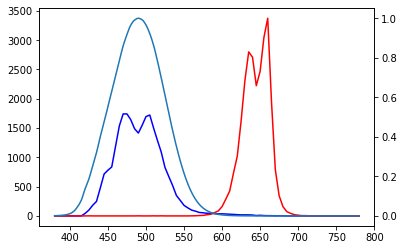

In [21]:
wlbins = stlab.get_wlbins()
from CIE import get_CIES026
_ , cies = get_CIES026(asdf=True)

f, ax = plt.subplots()
for stim in [red, blue]:
    d.spectruma(stim)
    sleep(.5)
    spec = d.get_spectrometer_spectrum(norm=False)
    print(np.sum(spec))
    ax.plot(wlbins, spec, c=stim)
    
d.turn_off()
ax2 = ax.twinx()
ax2.plot(cies["Mel"])

In [39]:
for stim in stims:
    name = "2s"+stim+"pulse"
    df = stlab.make_video_pulse(duration=2000, spec=stims[stim], video_nm=name, return_df=True)

'2sbluepulse.dsf' saved in the current working directory.
'2sredpulse.dsf' saved in the current working directory.


# Running the experiment

In [ ]:
# set up zmq context and remote helper for tracker
context = zmq.Context()
address = '127.0.0.1'  # remote ip or localhost
request_port = '50020'  # same as in the pupil remote gui
pupil_remote = zmq.Socket(context, zmq.REQ)
pupil_remote.connect('tcp://{}:{}'.format(address, request_port))

# Request 'SUB_PORT' for reading data
pupil_remote.send_string('SUB_PORT')
sub_port = pupil_remote.recv_string()

# Request 'PUB_PORT' for writing data
pupil_remote.send_string('PUB_PORT')
pub_port = pupil_remote.recv_string()

pub_socket = zmq.Socket(context, zmq.PUB)
pub_socket.connect('tcp://{}:{}'.format(address, pub_port))

pupil_remote.send_string('T {}'.format(time()))
print(pupil_remote.recv_string())
    
# Config Pupil Capture
#plh.notify(pupil_remote, {'subject':'start_plugin','name':'UVC_Source','args':{'frame_size': (640, 480),'frame_rate': 60,'name':'Pupil Cam1 ID2','exposure_mode':'manual'}})
notify(pupil_remote, {'subject':'start_plugin', 'name':'Annotation_Capture'})
#notify(pupil_remote, {'subject':'frame_publishing.set_format', 'format':'bgr'})

# setup stlab
d = stlab.Device(username='admin', identity=1, password='83e47941d9e930f6')

label = 'LIGHT_ON'
light_on_trigger = new_trigger(label, duration=2.)
threshold = 15
wait_time = 5.

In [ ]:
# start recording
pupil_remote.send_string('R plr_integration_tests')
pupil_remote.recv_string()

sleep(5.)  

for stim in ['2s_blue_pulse.dsf', '2s_red_pulse.dsf']*3:
    # make subscriber to frame.world
    subscriber = context.socket(zmq.SUB)
    subscriber.connect('tcp://{}:{}'.format(address, sub_port))
    subscriber.setsockopt_string(zmq.SUBSCRIBE, 'frame.world')
    
    # load video file and make trigger
    d.load_video_file(stim)
    light_on_trigger['stim'] = stim
    sleep(5.)
    # Running detect_light_onset in a background thread multiple times with
    # the same subscriber creates a race condition. Either
    # 1) only start one background thread
    # 2) let them use their own subscribers
    # 3) use a Lock to ensure that the same zmq message is not processed by different threads at the same time
    t = threading.Thread(target=detect_light_onset, 
                         args=(subscriber, 
                               pub_socket, 
                               light_on_trigger, 
                               threshold,
                               wait_time,))
    t.start()
    sleep(.2)
    # play the video file
    d.play_video_file()
    sleep(60.)  
    
sleep(5.)   
pupil_remote.send_string('r')
pupil_remote.recv_string()